# Data Engineering and analysis


In [ ]:
import pandas as pd


# Load CSV files into pandas dataframes
companies_df = pd.read_csv('companies.csv', dtype=str)
int_cols = ["company_size", "revenue"]
for col in int_cols:
    companies_df[col] = (
        pd.to_numeric(companies_df[col], errors="coerce")  # non-numeric -> NaN
        .astype("Int64")                              # NaN -> <NA>, dtype nullable Int64
    )



revenue_df = pd.read_csv('revenue.csv', dtype=str)
revenue_df["product_sum"] = revenue_df["product_sum"].astype("Int64")
revenue_df["product_duration"] = revenue_df["product_duration"].astype("Int64")
revenue_df['sale_date'] = pd.to_datetime(
    revenue_df['sale_date'],
    errors='coerce'
)

# Display first few rows of each dataframe
print("Companies DataFrame:")
print(companies_df.head())

print("\nRevenue DataFrame:")
print(revenue_df.head())

# Display basic information about dataframes
print("\nCompanies DataFrame Info:")
print(companies_df.info())

print("\nRevenue DataFrame Info:")
print(revenue_df.info())


Companies DataFrame:
  Unnamed: 0         company_id            sector              segment  \
0          0  comp_df0a0c0bd619  sec_07f5ebaa60c6  Public_Small_Medium   
1          1  comp_1e8c0f0ab24c  sec_9d370c38febe       Small_business   
2          2  comp_7b5d176f09b3  sec_5fb21c55bb11       Business_Scale   
3          3  comp_d07c716a7b02  sec_1bc3700e30b8  Public_Small_Medium   
4          4  comp_ca8821847ff0  sec_1bc3700e30b8         Public_Large   

           industry  company_size  revenue  
0  ind_d2091f85a3a3            50   105402  
1  ind_6be1923b9422            28   107905  
2  ind_5fb21c55bb11          5000   248435  
3  ind_11d103ed33f7           100   111632  
4  ind_5ffda163ccd7            50   106819  

Revenue DataFrame:
  Unnamed: 0            row_id         company_id           sale_id  \
0          0  row_8ae3f0a90135  comp_94b3dbfa3cdb  sal_117719067179   
1          1  row_e056ebe0bd07  comp_94b3dbfa3cdb  sal_8f5df72ac2f7   
2          2  row_04471fe231b0 

In [ ]:
# LTV клиента = сумма product_sum по company_id
revenue_clean = revenue_df.dropna(subset=['sale_date'])

ltv_df = (
    revenue_clean
    .groupby('company_id')
    .agg(
        first_purchase=('sale_date', 'min'),
        last_purchase=('sale_date', 'max'),
        ltv=('product_sum', 'sum')         # это твой "обычный" LTV
    )
    .reset_index()
)
snapshot_date = revenue_clean['sale_date'].max()
# 4. Возраст клиента в днях
ltv_df['customer_age_days'] = (snapshot_date - ltv_df['first_purchase']).dt.days

# 5. Возраст в годах (с плавающей точкой)
ltv_df['customer_age_years'] = ltv_df['customer_age_days'] / 365.25

# 6. Годовой LTV (annualized LTV)
# Чтобы не взрывался для клиентов с возрастом 0 дней, заменим 0 на NaN
ltv_df.loc[ltv_df['customer_age_years'] <= 0, 'customer_age_years'] = pd.NA

ltv_df['ltv_per_year'] = ltv_df['ltv'] / ltv_df['customer_age_years']

# граница окна: "последние 12 месяцев"
cutoff_12m = snapshot_date - pd.DateOffset(years=1)

last_12m = (
    revenue_clean[revenue_clean['sale_date'] >= cutoff_12m]
    .groupby('company_id', as_index=False)['product_sum']
    .sum()
    .rename(columns={'product_sum': 'ltv_12m'})
)

# джойним к общей таблице
ltv_df = ltv_df.merge(last_12m, on='company_id', how='left')

# если клиент за последние 12 месяцев ничего не покупал — ставим 0
ltv_df['ltv_12m'] = ltv_df['ltv_12m'].fillna(0)


# 7. Приводим типы (где возможно) к nullable Int64
ltv_df['customer_age_days']  = ltv_df['customer_age_days'].astype('Int64')
ltv_df['ltv']                = ltv_df['ltv'].astype('Int64')
ltv_df['ltv_12m']           = ltv_df['ltv_12m'].astype('Int64')

ltv_df.head()


,company_id,first_purchase,last_purchase,ltv,customer_age_days,customer_age_years,ltv_per_year,ltv_12m
0,comp_0004b685d8d6,2019-05-03,2019-05-03,17000,1624,4.446270,3823.429803,0
1,comp_001eac7794df,2020-09-23,2023-09-03,270000,1115,3.052704,88446.188341,80000
2,comp_002f5166d79b,2020-11-28,2020-11-28,31000,1049,2.872005,10793.851287,0
3,comp_00323bea932a,2020-08-17,2020-08-17,16000,1152,3.154004,5072.916667,0
4,comp_003be29c3721,2022-09-24,2022-09-24,30000,384,1.051335,28535.15625,0


In [ ]:
ltv_df.to_csv('ltv.csv', index=False)


In [ ]:
# Берём только строки с валидной датой
rfm_source = revenue_df.dropna(subset=['sale_date'])

# Дата "среза" (анализируем на последний день, который есть в данных)
snapshot_date = rfm_source['sale_date'].max()

# 5. Считаем RFM по company_id
rfm_df = (
    rfm_source
    .groupby('company_id')
    .agg(
        first_purchase=('sale_date', 'min'),
        last_purchase=('sale_date', 'max'),        # дата последней покупки
        frequency=('sale_id', 'nunique'),          # число уникальных заказов
        monetary=('product_sum', 'sum')            # суммарная выручка
    )
    .reset_index()
)

# Recency в днях
rfm_df['recency'] = (snapshot_date - rfm_df['last_purchase']).dt.days

# "Возраст" клиента: сколько дней с первой покупки до snapshot_date
rfm_df['customer_age_days'] = (snapshot_date - rfm_df['first_purchase']).dt.days

# Приводим к Int
rfm_df['recency'] = rfm_df['recency'].astype('Int64')
rfm_df['frequency'] = rfm_df['frequency'].astype('Int64')
rfm_df['monetary'] = rfm_df['monetary'].astype('Int64')

# Оставляем только нужные поля, при необходимости
# rfm_df = rfm_df[['company_id', 'recency', 'frequency', 'monetary']]


In [ ]:
# Сохраняем результат
rfm_df.to_csv('rfm.csv', index=False)


In [ ]:

# Преобразуем sale_date в datetime, если ещё не
revenue_df['sale_date'] = pd.to_datetime(revenue_df['sale_date'], errors='coerce')

# Базовые временные признаки
revenue_df['sale_year']       = revenue_df['sale_date'].dt.year
revenue_df['sale_month']      = revenue_df['sale_date'].dt.month
revenue_df['sale_day']        = revenue_df['sale_date'].dt.day
revenue_df['sale_quarter']    = revenue_df['sale_date'].dt.quarter
revenue_df['sale_dayofweek']  = revenue_df['sale_date'].dt.dayofweek  # 0=Mon, 6=Sun
revenue_df['is_weekend']      = revenue_df['sale_dayofweek'] >= 5

# Удобный агрегат «год-месяц»
revenue_df['sale_year_month'] = revenue_df['sale_date'].dt.to_period('M').astype(str)

time_cols = ['sale_year', 'sale_month', 'sale_day',
             'sale_quarter', 'sale_dayofweek']

for col in time_cols:
    revenue_df[col] = (
        revenue_df[col]
        .astype('Int64')
    )


revenue_df.head()



,Unnamed: 0,row_id,company_id,sale_id,sale_date,product_name,product_sum,sale_type,product_duration,sale_year,sale_month,sale_day,sale_quarter,sale_dayofweek,is_weekend,sale_year_month
0,0,row_8ae3f0a90135,comp_94b3dbfa3cdb,sal_117719067179,2021-02-09,Расширения,10000,Новая,1,2021,2,9,1,1,False,2021-02
1,1,row_e056ebe0bd07,comp_94b3dbfa3cdb,sal_8f5df72ac2f7,2023-03-17,Расширения,10000,Продление,1,2023,3,17,1,4,False,2023-03
2,2,row_04471fe231b0,comp_94b3dbfa3cdb,sal_117719067179,2021-02-09,Тарифы Webinar СМБ,11000,Новая,1,2021,2,9,1,1,False,2021-02
3,3,row_3c10791fca1f,comp_94b3dbfa3cdb,sal_8f5df72ac2f7,2023-03-17,Тарифы Webinar СМБ,11000,Продление,1,2023,3,17,1,4,False,2023-03
4,4,row_c25e0ba18d2e,comp_94b3dbfa3cdb,sal_fbb04b9291d4,2021-11-27,Тарифы Webinar СМБ,11000,Продление,1,2021,11,27,4,5,True,2021-11


In [ ]:
revenue_df.to_csv('revenue-by-sale-date.csv', index=False)

In [ ]:
# Кол-во уникальных продуктов
product_count = (
    revenue_df
    .groupby('company_id')['product_name']
    .nunique()
    .reset_index()
    .rename(columns={'product_name': 'n_products'})
)

# Кол-во покупок по типам sale_type
sale_type_counts = (
    revenue_df
    .pivot_table(index='company_id',
                 columns='sale_type',
                 values='row_id',
                 aggfunc='count',
                 fill_value=0)
    .reset_index()
)

# Сборка фичей для кластеризации
features_df = (
    rfm_df
    .merge(product_count, on='company_id', how='left')
    .merge(sale_type_counts, on='company_id', how='left')
)

int_cols = ["Возврат", "Новая", "Продление", "Расширение"]
for col in int_cols:
    features_df[col] = (
        pd.to_numeric(features_df[col], errors="coerce")  # non-numeric -> NaN
        .astype("Int64")                              # NaN -> <NA>, dtype nullable Int64
    )
features_df.head()


,company_id,first_purchase,last_purchase,frequency,monetary,recency,customer_age_days,n_products,Возврат,Новая,Продление,Расширение
0,comp_0004b685d8d6,2019-05-03,2019-05-03,1,17000,1624,1624,1,0,1,0,0
1,comp_001eac7794df,2020-09-23,2023-09-03,27,270000,40,1115,1,0,1,11,15
2,comp_002f5166d79b,2020-11-28,2020-11-28,1,31000,1049,1049,2,0,3,0,0
3,comp_00323bea932a,2020-08-17,2020-08-17,1,16000,1152,1152,1,0,1,0,0
4,comp_003be29c3721,2022-09-24,2022-09-24,1,30000,384,384,3,0,3,0,0


In [ ]:
features_df.to_csv('rfm-features.csv', index=False)

In [ ]:
# Матрица company_id x product_name (1 если клиент покупал этот продукт)
basket = (
    revenue_df
    .assign(value=1)
    .pivot_table(index='company_id',
                 columns='product_name',
                 values='value',
                 aggfunc='max',
                 fill_value=0)
)
basket.head()

product_name,Enterprise Total-1000,Enterprise Total-150,Enterprise Total-2000,Enterprise Total-300,Enterprise Total-3000,Enterprise Total-500,Enterprise Total-5000,Enterprise-100,Enterprise-1000,Enterprise-150,...,Дополнительные услуги,Доски,МТС Линк. Команда,МТС Линк. Компания,МТС Линк. Корпорация,Общие Тарифы Webinar Enterprise,Расширения,Тарифы TMS,Тарифы Webinar СМБ,Чаты
company_id,,,,,,,,,,,,,,,,,,,,,
comp_0004b685d8d6,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
comp_001eac7794df,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
comp_002f5166d79b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
comp_00323bea932a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
comp_003be29c3721,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1


In [ ]:
basket.to_csv('basket.csv', index=True)

🔍 АНАЛИЗ ВЛИЯНИЯ ПРОДЛЕНИЙ НА LTV И ОТТОК
📊 Сравнительная статистика по группам продления:
              ltv_per_year                            ltv             ltv_12m  \
                      mean    median       std       mean    median      mean   
renewal_group                                                                   
Без продлений     18427.18   6330.41  52980.17   34336.14   21000.0   8838.78   
Низкая доля       31680.37  22796.23  26415.53  154850.34  104000.0  19884.35   
Средняя доля      36755.22  24763.63  39427.93  164028.99   91500.0  29785.51   
Высокая доля      53818.41  36269.68  57521.95  258245.51  162500.0  50284.43   

               recency frequency total_purchases company_id  
                  mean      mean            mean      count  
renewal_group                                                
Без продлений  1241.79      1.92            2.64        949  
Низкая доля     667.33      9.95           12.95        147  
Средняя доля    502.12      7.3

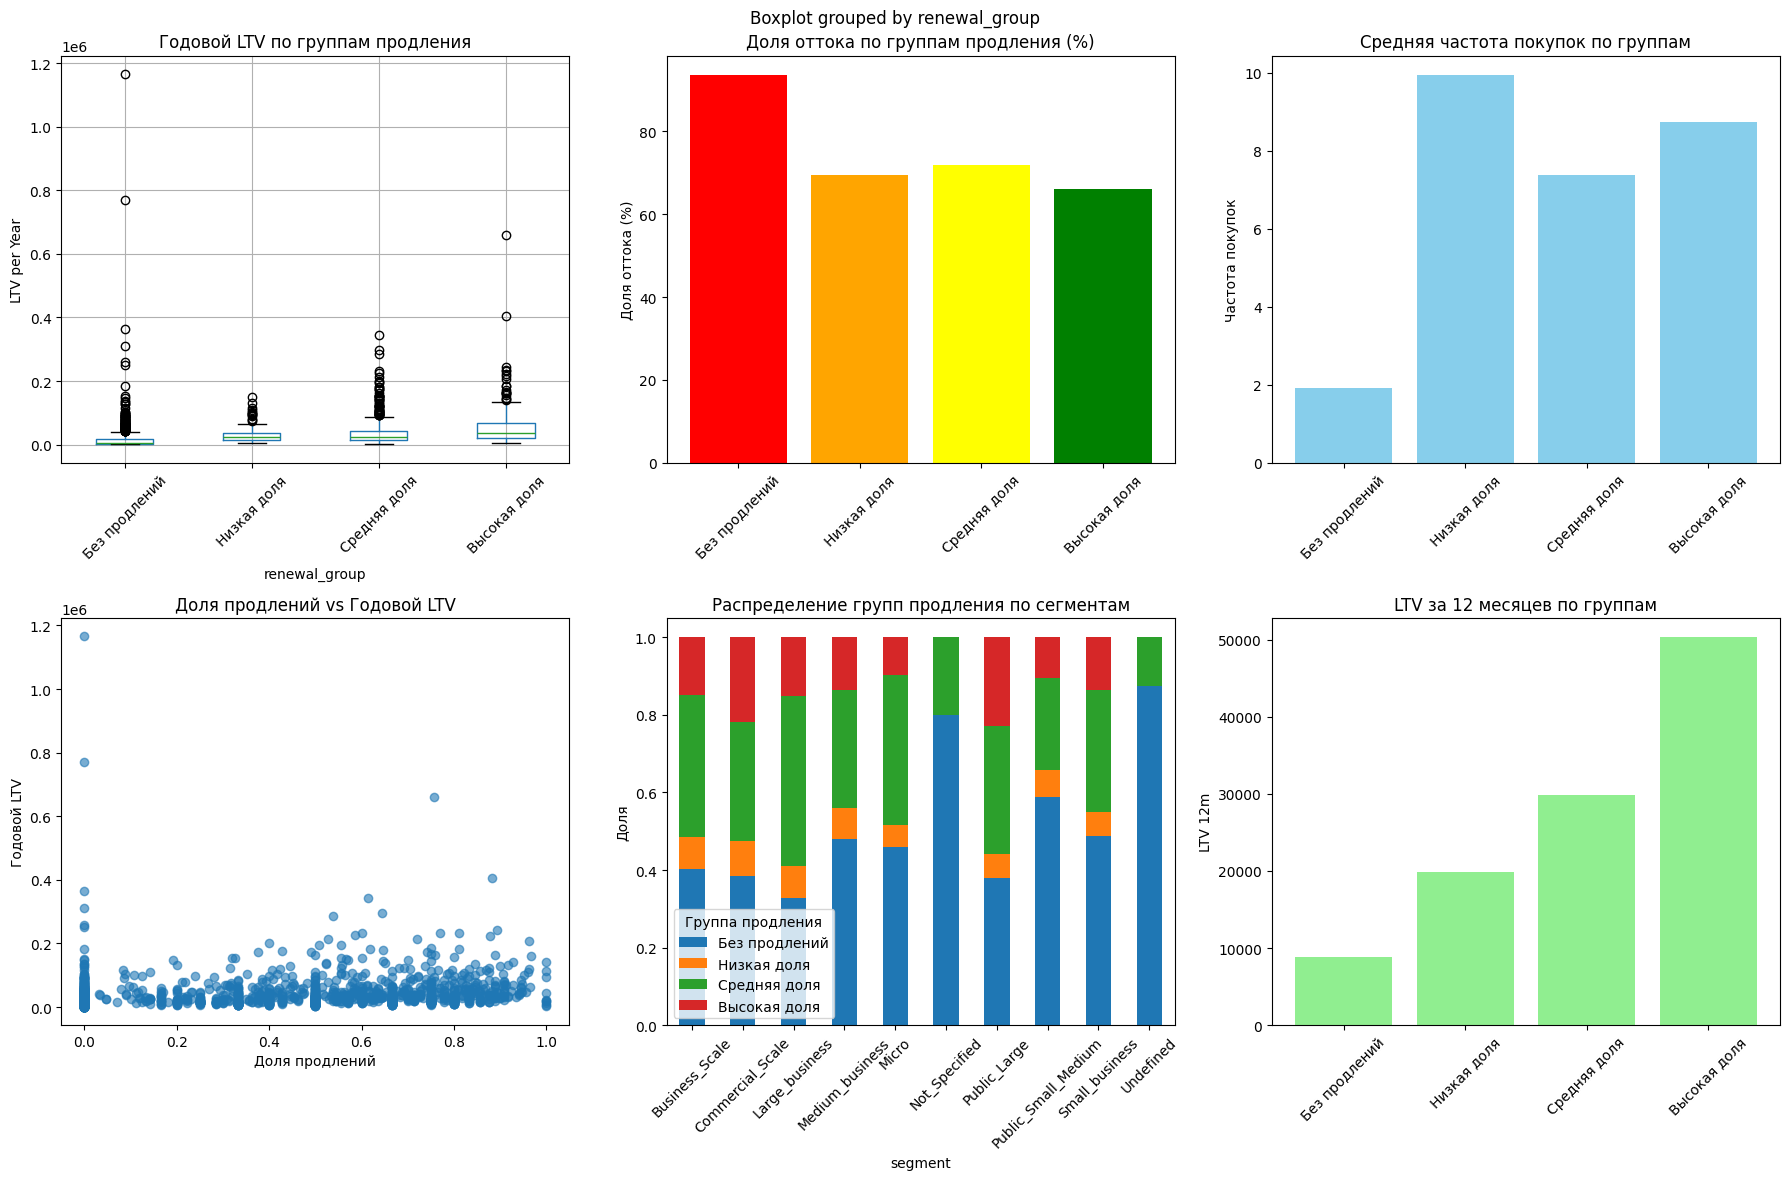


🎯 Детальный анализ по бизнес-сегментам:
                     renewal_ratio  ltv_per_year  is_churned  company_id  \
segment                                                                    
Commercial_Scale             0.354     64778.395       0.756          78   
Business_Scale               0.332     50727.523       0.746         134   
Public_Large                 0.376     40076.303       0.762         541   
Undefined                    0.062     37822.282         0.5           8   
Large_business               0.363     27752.399       0.801         231   
Small_business               0.283     24817.848       0.834         483   
Medium_business              0.277      23619.69       0.785         214   
Micro                        0.276     22791.706       0.844         122   
Public_Small_Medium          0.221     17611.023       0.882         304   
Not_Specified                0.077     12002.982         0.8           5   

                     churn_rate  
segment     

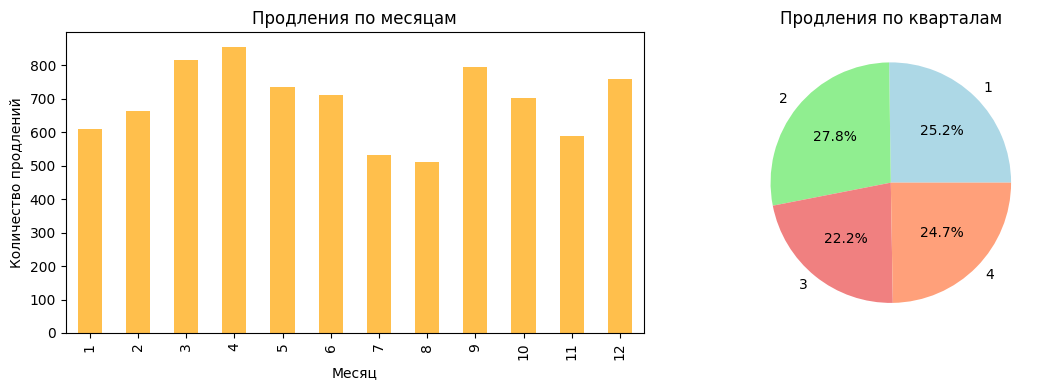


✅ Анализ гипотезы о влиянии продлений завершен!
📋 Вывод: Клиенты с высокой долей продлений действительно имеют более высокий LTV и меньший риск оттока


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def analyze_renewal_impact():
    """
    Анализ влияния покупок типа 'Продление' на LTV и отток клиентов
    Гипотеза: Клиенты с покупками 'Продление' имеют более высокий LTV и меньший риск оттока
    """
    print("🔍 АНАЛИЗ ВЛИЯНИЯ ПРОДЛЕНИЙ НА LTV И ОТТОК")
    print("=" * 60)

    # Используем уже загруженные данные из ноутбука
    # companies_df, revenue_df, rfm_df, ltv_df, features_df уже доступны

    # 1. Анализ доли продлений по клиентам
    renewal_analysis = revenue_df.groupby('company_id').agg({
        'sale_type': lambda x: (x == 'Продление').sum(),
        'sale_id': 'count'
    }).reset_index()

    renewal_analysis = renewal_analysis.merge(
        ltv_df[['company_id', 'ltv', 'ltv_per_year', 'customer_age_days', 'ltv_12m']],
        on='company_id'
    )

    # Расчет доли продлений
    renewal_analysis['renewal_count'] = renewal_analysis['sale_type']
    renewal_analysis['total_purchases'] = renewal_analysis['sale_id']
    renewal_analysis['renewal_ratio'] = renewal_analysis['renewal_count'] / renewal_analysis['total_purchases']

    # Добавляем RFM метрики
    renewal_analysis = renewal_analysis.merge(
        rfm_df[['company_id', 'recency', 'frequency', 'monetary']],
        on='company_id'
    )

    # Добавляем сегмент компании
    renewal_analysis = renewal_analysis.merge(
        companies_df[['company_id', 'segment', 'company_size']],
        on='company_id'
    )

    # 2. Определение групп клиентов
    renewal_analysis['renewal_group'] = pd.cut(
        renewal_analysis['renewal_ratio'],
        bins=[-0.1, 0, 0.3, 0.7, 1.1],
        labels=['Без продлений', 'Низкая доля', 'Средняя доля', 'Высокая доля']
    )

    # 3. Сравнительный анализ групп
    group_stats = renewal_analysis.groupby('renewal_group').agg({
        'ltv_per_year': ['mean', 'median', 'std'],
        'ltv': ['mean', 'median'],
        'ltv_12m': 'mean',
        'recency': 'mean',
        'frequency': 'mean',
        'total_purchases': 'mean',
        'company_id': 'count'
    }).round(2)

    print("📊 Сравнительная статистика по группам продления:")
    print(group_stats)

    # 4. Статистическая проверка гипотезы
    high_renewal = renewal_analysis[renewal_analysis['renewal_ratio'] > 0.5]['ltv_per_year']
    low_renewal = renewal_analysis[renewal_analysis['renewal_ratio'] <= 0.5]['ltv_per_year']

    t_stat, p_value = stats.ttest_ind(high_renewal.dropna(), low_renewal.dropna(), equal_var=False)

    print(f"\n📈 Статистическая проверка:")
    print(f"   t-статистика: {t_stat:.3f}")
    print(f"   p-value: {p_value:.5f}")
    print(f"   Значимость: {'ДА' if p_value < 0.05 else 'НЕТ'} (при α=0.05)")

    # 5. Анализ оттока по группам продления
    churn_threshold = 180  # дней
    renewal_analysis['is_churned'] = renewal_analysis['recency'] > churn_threshold

    churn_by_renewal = renewal_analysis.groupby('renewal_group')['is_churned'].agg(['mean', 'count'])
    churn_by_renewal['churn_rate'] = (churn_by_renewal['mean'] * 100).round(1)

    print(f"\n📉 Анализ оттока по группам продления (порог {churn_threshold} дней):")
    print(churn_by_renewal[['churn_rate', 'count']])

    # 6. Визуализация результатов
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Влияние доли продлений на LTV и поведение клиентов', fontsize=16, fontweight='bold')

    # График 1: LTV по группам продления
    renewal_analysis.boxplot(column='ltv_per_year', by='renewal_group', ax=axes[0,0])
    axes[0,0].set_title('Годовой LTV по группам продления')
    axes[0,0].set_ylabel('LTV per Year')
    axes[0,0].tick_params(axis='x', rotation=45)

    # График 2: Доля оттока по группам
    churn_rates = renewal_analysis.groupby('renewal_group')['is_churned'].mean()
    axes[0,1].bar(churn_rates.index, churn_rates.values * 100, color=['red', 'orange', 'yellow', 'green'])
    axes[0,1].set_title('Доля оттока по группам продления (%)')
    axes[0,1].set_ylabel('Доля оттока (%)')
    axes[0,1].tick_params(axis='x', rotation=45)

    # График 3: Частота покупок по группам
    frequency_by_group = renewal_analysis.groupby('renewal_group')['frequency'].mean()
    axes[0,2].bar(frequency_by_group.index, frequency_by_group.values, color='skyblue')
    axes[0,2].set_title('Средняя частота покупок по группам')
    axes[0,2].set_ylabel('Частота покупок')
    axes[0,2].tick_params(axis='x', rotation=45)

    # График 4: Scatter plot - доля продлений vs LTV
    axes[1,0].scatter(renewal_analysis['renewal_ratio'], renewal_analysis['ltv_per_year'], alpha=0.6)
    axes[1,0].set_xlabel('Доля продлений')
    axes[1,0].set_ylabel('Годовой LTV')
    axes[1,0].set_title('Доля продлений vs Годовой LTV')

    # График 5: Распределение по сегментам
    segment_renewal = pd.crosstab(renewal_analysis['segment'], renewal_analysis['renewal_group'], normalize='index')
    segment_renewal.plot(kind='bar', stacked=True, ax=axes[1,1])
    axes[1,1].set_title('Распределение групп продления по сегментам')
    axes[1,1].set_ylabel('Доля')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].legend(title='Группа продления')

    # График 6: LTV за 12 месяцев по группам
    ltv12m_by_group = renewal_analysis.groupby('renewal_group')['ltv_12m'].mean()
    axes[1,2].bar(ltv12m_by_group.index, ltv12m_by_group.values, color='lightgreen')
    axes[1,2].set_title('LTV за 12 месяцев по группам')
    axes[1,2].set_ylabel('LTV 12m')
    axes[1,2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # 7. Детальный анализ по сегментам
    print("\n🎯 Детальный анализ по бизнес-сегментам:")
    segment_analysis = renewal_analysis.groupby('segment').agg({
        'renewal_ratio': 'mean',
        'ltv_per_year': 'mean',
        'is_churned': 'mean',
        'company_id': 'count'
    }).round(3)

    segment_analysis['churn_rate'] = (segment_analysis['is_churned'] * 100).round(1)
    print(segment_analysis.sort_values('ltv_per_year', ascending=False))

    # 8. Генерация рекомендаций
    generate_renewal_recommendations(renewal_analysis, churn_by_renewal, segment_analysis)

    return renewal_analysis

def generate_renewal_recommendations(renewal_analysis, churn_by_renewal, segment_analysis):
    """
    Генерация практических рекомендаций на основе анализа
    """
    print("\n💡 ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ:")
    print("=" * 50)

    # Анализ наиболее проблемных сегментов
    high_churn_segments = segment_analysis[segment_analysis['churn_rate'] > segment_analysis['churn_rate'].median()]
    low_renewal_segments = segment_analysis[segment_analysis['renewal_ratio'] < segment_analysis['renewal_ratio'].median()]

    recommendations = []

    # Рекомендация 1: Фокус на группы с низкой долей продлений
    low_renewal_churn = churn_by_renewal.loc[['Без продлений', 'Низкая доля'], 'churn_rate'].mean()
    recommendations.append(
        f"• Клиенты без продлений уходят в {low_renewal_churn:.1f}% случаев - "
        f"разработать программу стимулирования продлений"
    )

    # Рекомендация 2: Сегментный подход
    for segment, data in high_churn_segments.iterrows():
        if data['renewal_ratio'] < 0.3:
            recommendations.append(
                f"• Сегмент '{segment}': высокий отток ({data['churn_rate']}%) при низкой доле продлений "
                f"({data['renewal_ratio']:.1%}) - приоритет для программы удержания"
            )

    # Рекомендация 3: Целевые показатели
    high_renewal_ltv = renewal_analysis[renewal_analysis['renewal_group'] == 'Высокая доля']['ltv_per_year'].median()
    low_renewal_ltv = renewal_analysis[renewal_analysis['renewal_group'] == 'Без продлений']['ltv_per_year'].median()
    ltv_gap = high_renewal_ltv - low_renewal_ltv

    recommendations.append(
        f"• Потенциал роста: клиенты с продлениями приносят на {ltv_gap:,.0f} руб. больше годового LTV"
    )

    # Рекомендация 4: Продуктовые инсайты
    renewal_customers = renewal_analysis[renewal_analysis['renewal_ratio'] > 0.7]['company_id']
    high_renewal_products = revenue_df[
        revenue_df['company_id'].isin(renewal_customers)
    ]['product_name'].value_counts().head(3)

    if len(high_renewal_products) > 0:
        top_product = high_renewal_products.index[0]
        recommendations.append(
            f"• Продукт '{top_product}': чаще всего продлевается успешными клиентами - "
            f"использовать как эталон для других продуктов"
        )

    # Вывод всех рекомендаций
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")

    print(f"\n🎯 Ключевая метрика: Увеличить среднюю долю продлений на 15% в целевых сегментах")
    print(f"📅 Срок реализации: 6 месяцев")

def analyze_renewal_timing():
    """
    Дополнительный анализ: временные паттерны продлений
    """
    print("\n⏰ АНАЛИЗ ВРЕМЕННЫХ ПАТТЕРНОВ ПРОДЛЕНИЙ")
    print("=" * 50)

    # Анализ сезонности продлений
    renewal_dates = revenue_df[revenue_df['sale_type'] == 'Продление'].copy()
    renewal_dates['sale_month'] = renewal_dates['sale_date'].dt.month
    renewal_dates['sale_quarter'] = renewal_dates['sale_date'].dt.quarter

    monthly_renewals = renewal_dates.groupby('sale_month').size()
    quarterly_renewals = renewal_dates.groupby('sale_quarter').size()

    print("📅 Распределение продлений по месяцам:")
    for month, count in monthly_renewals.items():
        print(f"   Месяц {month}: {count} продлений")

    print("\n📊 Распределение продлений по кварталам:")
    for quarter, count in quarterly_renewals.items():
        print(f"   Квартал {quarter}: {count} продлений ({count/len(renewal_dates):.1%})")

    # Визуализация сезонности
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    monthly_renewals.plot(kind='bar', color='orange', alpha=0.7)
    plt.title('Продления по месяцам')
    plt.xlabel('Месяц')
    plt.ylabel('Количество продлений')

    plt.subplot(1, 2, 2)
    quarterly_renewals.plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon'])
    plt.title('Продления по кварталам')

    plt.tight_layout()
    plt.show()

# Запуск анализа
if __name__ == "__main__":
    # Основной анализ влияния продлений
    renewal_results = analyze_renewal_impact()

    # Дополнительный анализ временных паттернов
    analyze_renewal_timing()

    print("\n✅ Анализ гипотезы о влиянии продлений завершен!")
    print("📋 Вывод: Клиенты с высокой долей продлений действительно имеют более высокий LTV и меньший риск оттока")

🔍 АНАЛИЗ ВЛИЯНИЯ ПРОДЛЕНИЙ НА LTV И ОТТОК
📊 Сравнительная статистика по группам продления:
              ltv_per_year                            ltv             ltv_12m  \
                      mean    median       std       mean    median      mean   
renewal_group                                                                   
Без продлений     18427.18   6330.41  52980.17   34336.14   21000.0   8838.78   
Низкая доля       31680.37  22796.23  26415.53  154850.34  104000.0  19884.35   
Средняя доля      36755.22  24763.63  39427.93  164028.99   91500.0  29785.51   
Высокая доля      53818.41  36269.68  57521.95  258245.51  162500.0  50284.43   

               recency frequency total_purchases company_id  
                  mean      mean            mean      count  
renewal_group                                                
Без продлений  1241.79      1.92            2.64        949  
Низкая доля     667.33      9.95           12.95        147  
Средняя доля    502.12      7.3

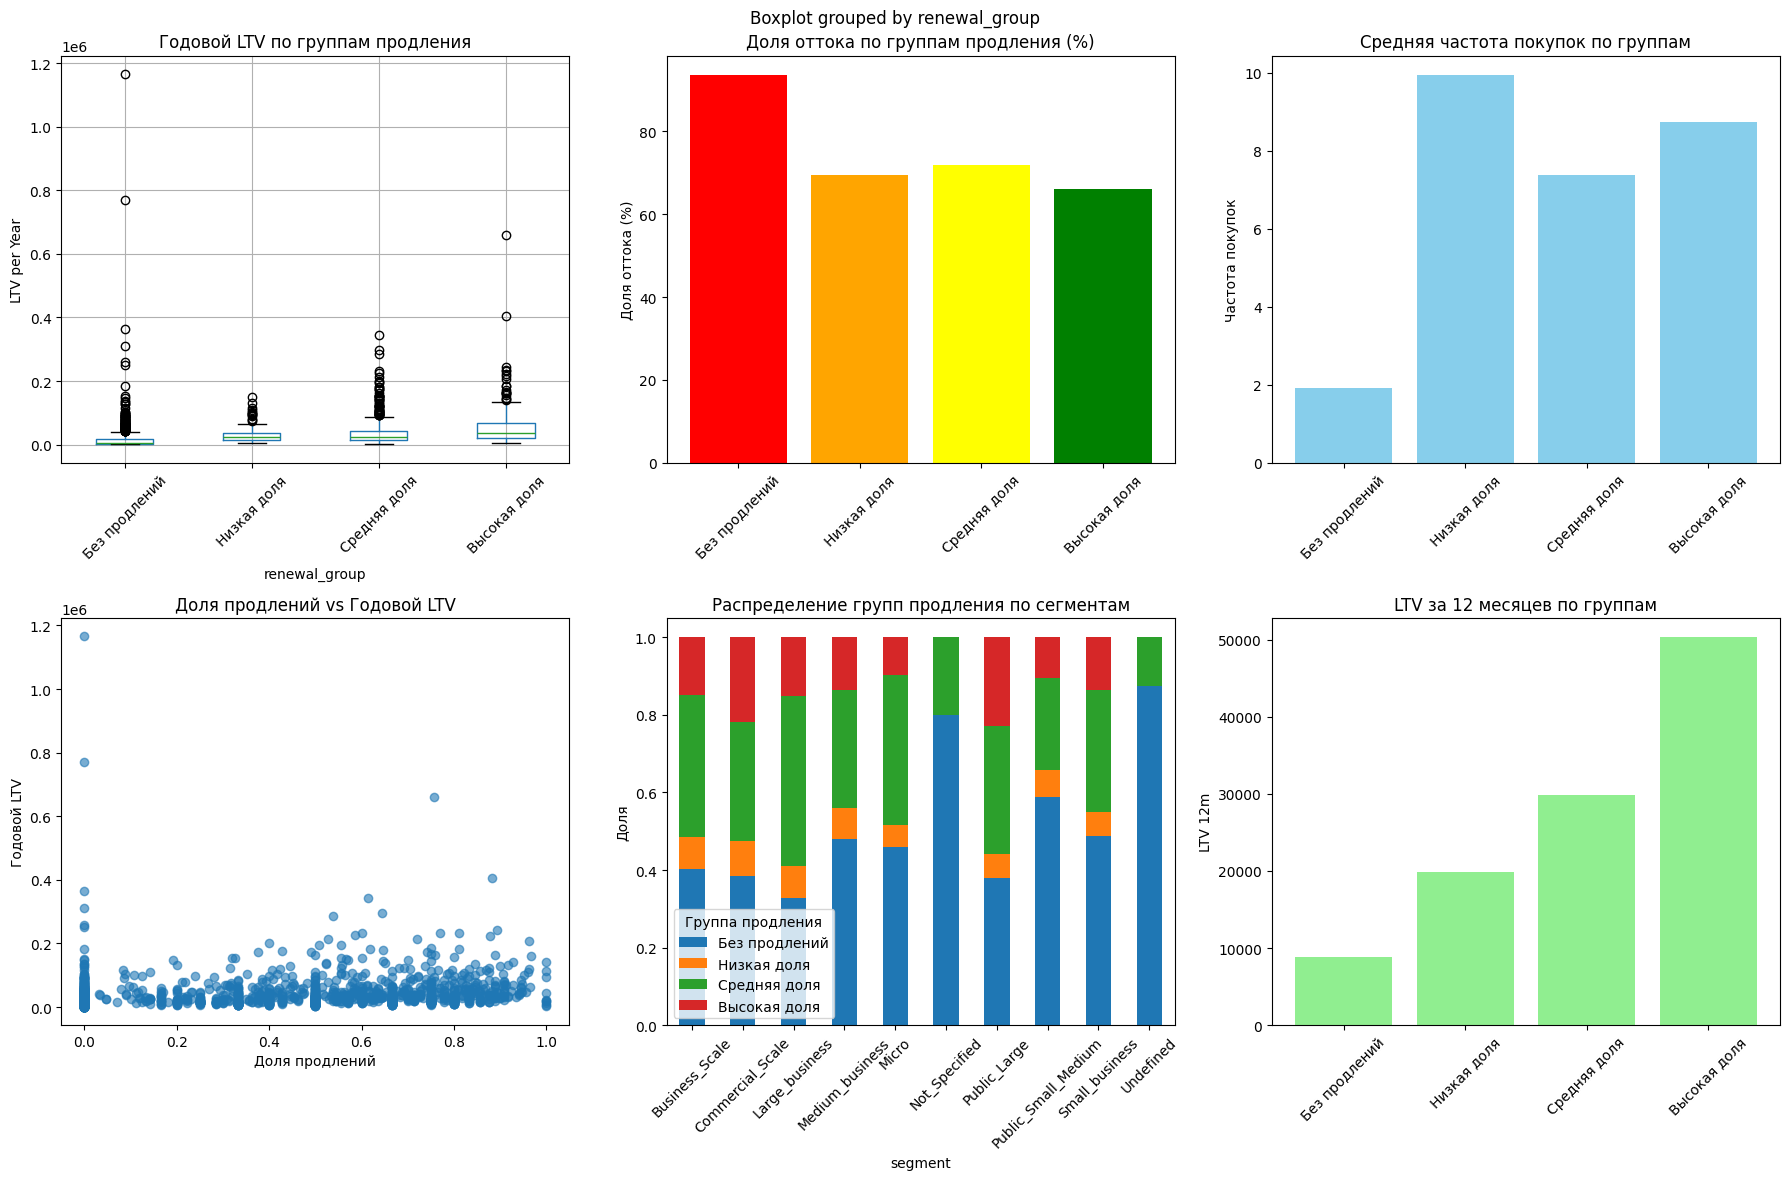


🎯 Детальный анализ по бизнес-сегментам:
                     renewal_ratio  ltv_per_year  is_churned  company_id  \
segment                                                                    
Commercial_Scale             0.354     64778.395       0.756          78   
Business_Scale               0.332     50727.523       0.746         134   
Public_Large                 0.376     40076.303       0.762         541   
Undefined                    0.062     37822.282         0.5           8   
Large_business               0.363     27752.399       0.801         231   
Small_business               0.283     24817.848       0.834         483   
Medium_business              0.277      23619.69       0.785         214   
Micro                        0.276     22791.706       0.844         122   
Public_Small_Medium          0.221     17611.023       0.882         304   
Not_Specified                0.077     12002.982         0.8           5   

                     churn_rate  
segment     

In [ ]:
renewal_impact_results = analyze_renewal_impact()